In [1]:
from qkit.analysis.semiconductor.loaders.Loaderh5 import Loaderh5
from qkit.analysis.semiconductor.main.loading import print_nodes
from qkit.analysis.semiconductor.analyzers.AnalyzerTimetraceSpectralNoiseDensity import AnalyzerTimetraceSpectralNoiseDensity
from qkit.analysis.semiconductor.plotters.PlotterTimetraceSpectralNoiseDensity import PlotterTimetraceSpectralNoiseDensity
from qkit.analysis.semiconductor.analyzers.AnalyzerPeakTracker_Daniel import AnalyzerPeakTracker
from qkit.analysis.semiconductor.analyzers.AnalyzerTimetraceJumps import AnalyzerTimetraceJumps
from qkit.analysis.semiconductor.plotters.PlotterPlungerTimetrace3D import PlotterPlungerTimetrace3D
from qkit.analysis.semiconductor.plotters.PlotterPlungerTraceFit import PlotterPlungerTraceFit
from qkit.analysis.semiconductor.plotters.PlotterPlungerTraceTimestampsDifference import PlotterPlungerTraceTimestampsDifference
from qkit.analysis.semiconductor.plotters.PlotterTimetraceJumpsHistogram import PlotterTimetraceJumpsHistogram
from qkit.analysis.semiconductor.main.SlicerPlungerTimetrace import SlicerPlungerTimetrace
from qkit.analysis.semiconductor.loaders.Loader_spectrum_np import Loader_spectrum_np
from qkit.analysis.semiconductor.savers.Saver_spectrum_np import Saver_spectrum_np

QKIT configuration initialized -> available as qkit.cfg[...]


In [2]:
filepath = "/V/GroupWernsdorfer/SEMICONDUCTOR_SYSTEMS/Presentations/2022_06_13/Data/002320_2D_Peak_tracking_lowest_TG/002320_2D_Peak_tracking.h5"

settings = {"file_info" : {
                "filepath" : filepath,
                "savepath" : "analysis/",
                "analysis" : "plunger_sweep_timetrace"},
            "meas_params" : {
                "measurement_amp" : 100e-6,
                "voltage_divider" : 3,
                "IVgain" : 1e8,
                "in_line_R": 40e3}
            }

In [3]:
loader = Loaderh5()
data = loader.load(settings)
print_nodes(data)

Done loading file, formatting now...

Data nodes:
['demod0&4.r0', 'demod0&4.r4', 'demod0&4.timestamp0', 'demod0&4.timestamp4', 'demod0&4.x0', 'demod0&4.x4', 'demod0&4.y0', 'demod0&4.y4', 'gates_6_16', 'measurement', 'number', 'settings', 'static_voltages']


In [4]:
node_timestamp = "demod0&4.timestamp0"
node_x = "demod0&4.x0"
node_y = "demod0&4.y0"
node_r = "demod0&4.r0"

gates = "gates_6_16"

/V/GroupWernsdorfer/People/Thomas/qkit-master/qkitMaster/qkit/analysis/semiconductor/plotters/PlotterPlungerTimetrace3D.py:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(data_time, data[nodes[1]], data_z, cmap=cmap, norm=norm)


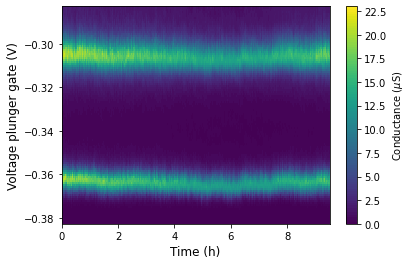

In [5]:
plotter = PlotterPlungerTimetrace3D()
plotter.max_cond = None
plotter.plot(settings, data, [node_timestamp, gates , node_r])

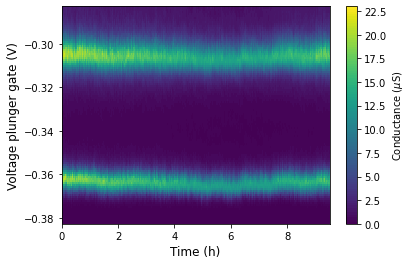

In [6]:
#%% Slice Data and Plot
slicer = SlicerPlungerTimetrace()
slicer.beginning, slicer.ending = 0, 10 # in hours
data_sliced = slicer.slice(data, [node_timestamp, gates , node_r])

plotter = PlotterPlungerTimetrace3D()
plotter.max_cond = None
plotter.savename = "plunger_timetrace_sliced"
plotter.plot(settings, data_sliced, [node_timestamp, gates , node_r])

In [85]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from qkit.analysis.semiconductor.main.find_index_of_value import map_array_to_index
from qkit.analysis.semiconductor.main.time_conversion import convert_secs_2D

data, nodes = data_sliced, [node_timestamp, gates , node_r]

intervall1 = 0.02
intervall2 = 0.01
peak_voltage = -0.36
max_iter = 10000
init_params = None

def sech(x, a, b, c, d):
    '''hyperbolic secans function'''
    return a * (1 / np.cosh(b * (x - c))) + d # return is scaled in Volts

if init_params is None:
    # initial parameters for fit
    a, b, d = 0.01, -0.1, 0.0
else:
    a, b, d = init_params[0], init_params[1], init_params[2]

peak_index = map_array_to_index(data[nodes[1]], peak_voltage)
intervall1_half_index = map_array_to_index(data[nodes[1]], abs(intervall1 / 2) + data[nodes[1]][0])
intervall2_half_index= map_array_to_index(data[nodes[1]], abs(intervall2 / 2) + data[nodes[1]][0])

p0 = [a, b, peak_index, d]  #initatal guess of a, b, c, d
timestamps = convert_secs_2D(data[nodes[0]])
length_sweep = len(timestamps)
data["timestamps_diff"] = np.diff(timestamps)
data["avg_sweep_time"] = np.average(np.diff(timestamps)) 
data["peaks_plunger_V"] =  np.array([None] * length_sweep) # initialize None array for peaks
data["peaks_value"] =  np.array([None] * length_sweep)
data["peaks_plunger_V_cov"] =  np.array([None] * length_sweep)
data["peaks_fit_popts"] =  np.array([None] * length_sweep)
data["peaks_fit_intervall_half"] = intervall2_half_index # saves the index size of the fit intervall/2


for trace_num in range(len(10)):
    try:
        # bigger intervall, first fit
        popt, pcov = curve_fit(sech, np.arange(peak_index-intervall1_half_index, peak_index+intervall1_half_index, 1), 
            data[nodes[2]][trace_num][peak_index-intervall1_half_index : peak_index+intervall1_half_index], p0, maxfev=max_iter)
        peak_fitted_index = int(round(popt[2]))

        try:
            # smaller intervall, second fit around peak of first fit
            if peak_fitted_index > intervall2_half_index and peak_fitted_index < (length_sweep-intervall2_half_index):
                p1 = [a, b, peak_fitted_index, d]

                popt1, pcov1 = curve_fit(sech, np.arange(peak_fitted_index-intervall2_half_index, peak_fitted_index+intervall2_half_index, 1),
                    data[nodes[2]][trace_num][peak_fitted_index-intervall2_half_index : peak_fitted_index+intervall2_half_index], p1, maxfev=max_iter)

                data["peaks_plunger_V"][trace_num] = data[nodes[1]][int(round(popt1[2]))] # plunger gate voltage of peak 
                data["peaks_value"][trace_num] = sech(popt1[2], *popt1) # lock-in value of fitted peak
                data["peaks_plunger_V_cov"][trace_num] = pcov1 # covariance on index of peak
                data["peaks_fit_popts"][trace_num] = popt1 # values of [a, b, c, d]
                plt.plot("")
                if pcov1[2][2] > 1:
                    print("COV TOO BIG  ", trace_num)  
                    data["peaks_plunger_V"][trace_num] = None 
                    data["peaks_value"][trace_num] = None
                    data["peaks_plunger_V_cov"][trace_num] = None
                    data["peaks_fit_popts"][trace_num] = None

            else:
                print("Peak not found in first fit")
                data["peaks_plunger_V"][trace_num] = None 
                data["peaks_value"][trace_num] = None
                data["peaks_plunger_V_cov"][trace_num] = None
                data["peaks_fit_popts"][trace_num] = None


        except RuntimeError:
            print("RUNTIME ERROR second ", trace_num)
            pass

    except RuntimeError:
        print("RUNTIME ERROR first ", trace_num)
        pass





In [32]:
analyzer = AnalyzerPeakTracker()

analyzer.intervall1 = 0.03
analyzer.intervall2 = 0.015
analyzer.peak_voltage = -0.305
analyzer.analyze( data_sliced, [node_timestamp, gates , node_r])

/home/ws/tp1435/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


IndexError: index 154 is out of bounds for axis 0 with size 110

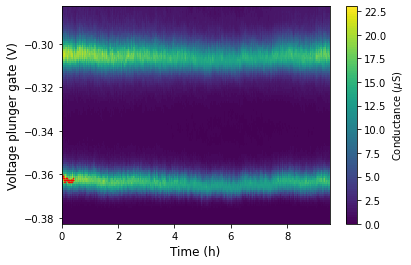

In [9]:
plotter = PlotterPlungerTimetrace3D()
plotter.point_size = 0.5
plotter.marker_shape = "or"
#plotter.max_cond = 10
plotter.savename = "plunger_timetrace_sliced_fitted"
plotter.plot(settings, data_sliced, [node_timestamp, gates , node_r])

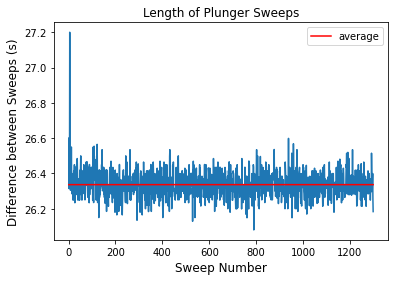

In [66]:
plotter = PlotterPlungerTraceTimestampsDifference()
plotter.plot(settings, data_sliced)


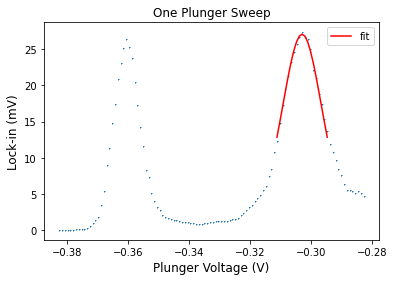

In [33]:
plotter = PlotterPlungerTraceFit()
plotter.trace_num = 2
plotter.plot(settings, data_sliced,  [gates , node_r])

max jump positive (mV) :  1.4032202754411665
max jump negative (mV) :  1.7653739989257067


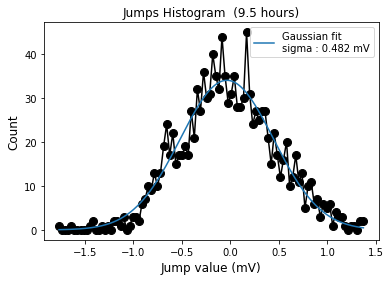

In [77]:
analyzer_jumps = AnalyzerTimetraceJumps()
analyzer_jumps.bin_count = 100
jumps_hist = analyzer_jumps.analyze_difference(data_sliced, ["peaks_value", node_timestamp])

plotter_hist = PlotterTimetraceJumpsHistogram()
plotter_hist.marker_size = 8
plotter_hist.plot(settings, jumps_hist)

In [74]:
sampling_f = 1/data_sliced["avg_sweep_time"]  
analyzer_SND = AnalyzerTimetraceSpectralNoiseDensity()
spectral_result = analyzer_SND.analyze(sampling_f, data_sliced, ["peaks_plunger_V"]) # classic Fourier

saver = Saver_spectrum_np() # Saving Data
saver.save(settings, spectral_result, ending="Fourier")

analyzer_SND.segment_length = 50 # length of each segment for Welch
spectral_result_welch = analyzer_SND.analyze_welch(sampling_f, data_sliced, ["peaks_plunger_V"]) # Welch's method

saver = Saver_spectrum_np() # Saving Data
saver.save(settings, spectral_result_welch, ending="Welch")

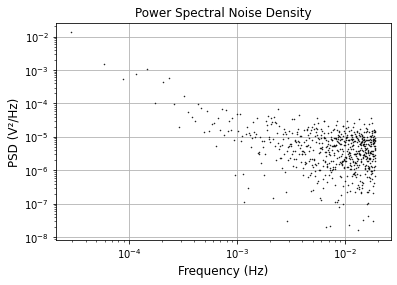

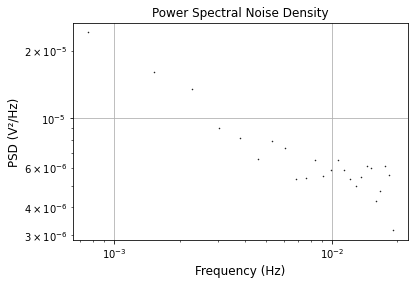

In [75]:
plotter_SND = PlotterTimetraceSpectralNoiseDensity()
plotter.savename = "SND"
plotter_SND.plot(settings, spectral_result) # classic Fourier

plotter_SND = PlotterTimetraceSpectralNoiseDensity()
plotter.savename = "SND_welch"
plotter_SND.plot(settings, spectral_result_welch) # Welch's method